_Task 1: Inner Workings of ResNet-152_

_3. Feature Hierarchies and Representations_

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet152
import tqdm
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

Using pre-trained ResNet-152.
Replacing the final classification layer to match CIFAR-10.
Freezing the rest of the backbone so that only the classification head is trained.

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet152(weights='IMAGENET1K_V1')
model.fc = nn.Linear(model.fc.in_features, 10)
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True
model = model.to(device)
print(device)

cuda


Feature extraction

In [7]:
features = {
    "early_layer1": [],
    "middle_layer3": [],
    "final_avgpool": []
}
hooks = []

def get_features(name):
    def hook(module, input, output):
        if name in ["early_layer1", "middle_layer3"]:
            pooled = torch.nn.functional.adaptive_avg_pool2d(output, (1,1))
            features[name].append(pooled.detach().cpu())
        else:
            features[name].append(output.detach().cpu())
    return hook

hooks.append(model.layer1.register_forward_hook(get_features("early_layer1")))
hooks.append(model.layer3[7].register_forward_hook(get_features("middle_layer3")))
hooks.append(model.avgpool.register_forward_hook(get_features("final_avgpool")))


Preparing dataloaders

In [8]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=12, shuffle=True, num_workers=2
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=12, shuffle=False, num_workers=2
)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.02, momentum=0.9)

In [10]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    avg_loss = running_loss / total
    accuracy = 100. * correct / total
    return avg_loss, accuracy


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    avg_loss = running_loss / total
    accuracy = 100. * correct / total
    return avg_loss, accuracy

In [11]:
num_epochs = 3
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, trainloader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, testloader, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.2f}%")

Epoch 1/3
  Train Loss: 2.7200 | Train Acc: 68.64%
  Val   Loss: 1.8849 | Val   Acc: 78.44%
Epoch 2/3
  Train Loss: 2.6221 | Train Acc: 72.81%
  Val   Loss: 2.0282 | Val   Acc: 79.18%
Epoch 3/3
  Train Loss: 2.5865 | Train Acc: 74.24%
  Val   Loss: 3.8492 | Val   Acc: 73.68%


In [12]:
def collect_features(model, loader, device, max_samples=2000):
    model.eval()

    feats = {"early": [], "middle": [], "late": []}
    labels = []

    for k in features.keys():
        features[k] = []

    collected = 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            _ = model(inputs)

            batch_size = inputs.size(0)
            labels.append(targets.cpu())

            # Append flattened outputs
            if len(features["early_layer1"]) > 0:
                feats["early"].append(features["early_layer1"][-1].flatten(1))
            if len(features["middle_layer3"]) > 0:
                feats["middle"].append(features["middle_layer3"][-1].flatten(1))
            if len(features["final_avgpool"]) > 0:
                feats["late"].append(features["final_avgpool"][-1].flatten(1))

            collected += batch_size
            if collected >= max_samples:
                break

    feats = {k: torch.cat(v, dim=0)[:max_samples].numpy() for k, v in feats.items()}
    labels = torch.cat(labels, dim=0)[:max_samples].numpy()

    return feats, labels

In [13]:
feats, labels = collect_features(model, testloader, device, max_samples=2000)
print("Early (layer1):", feats["early"].shape)
print("Middle (layer3[7]):", feats["middle"].shape)
print("Late (avgpool):", feats["late"].shape)

Early (layer1): (2000, 256)
Middle (layer3[7]): (2000, 1024)
Late (avgpool): (2000, 2048)


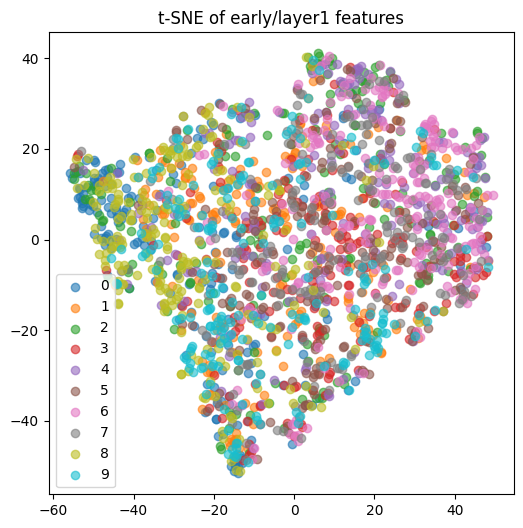

In [14]:
X = feats["early"]
y = labels
# t-SNE to 2D
X_2d = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X)
plt.figure(figsize=(6,6))
for c in range(10):
    plt.scatter(X_2d[y==c,0], X_2d[y==c,1], label=str(c), alpha=0.6)
plt.legend()
plt.title("t-SNE of early/layer1 features")
plt.show()


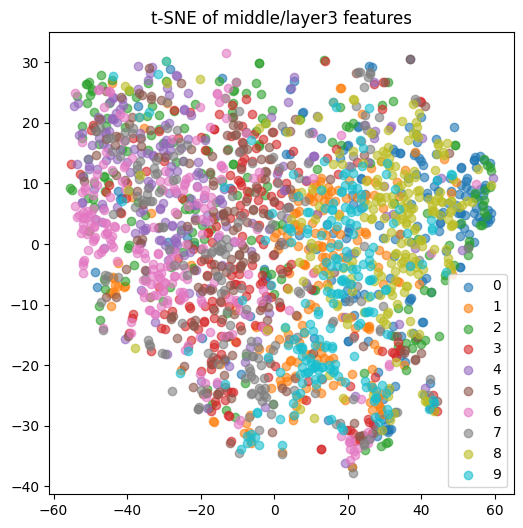

In [15]:
X = feats["middle"]
y = labels
X_2d = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X)
plt.figure(figsize=(6,6))
for c in range(10):
    plt.scatter(X_2d[y==c,0], X_2d[y==c,1], label=str(c), alpha=0.6)
plt.legend()
plt.title("t-SNE of middle/layer3 features")
plt.show()

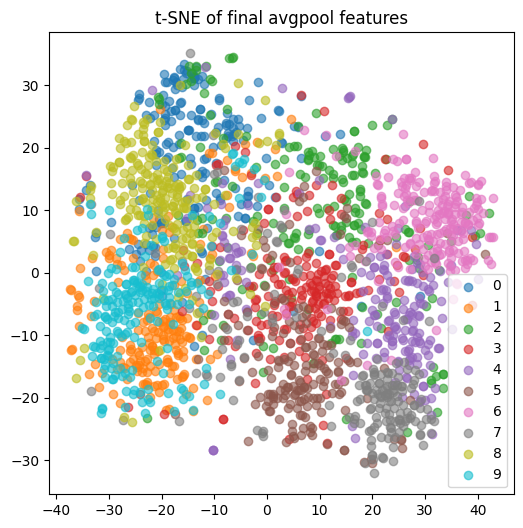

In [16]:
X = feats["late"]
y = labels
X_2d = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X)
plt.figure(figsize=(6,6))
for c in range(10):
    plt.scatter(X_2d[y==c,0], X_2d[y==c,1], label=str(c), alpha=0.6)
plt.legend()
plt.title("t-SNE of final avgpool features")
plt.show()